# Create Model & Training Model

In [13]:
#!pip install scikit-image
#!pip install imageio
#!pip install mediapipe

     --------------------------------------- 49.8/49.8 MB 54.7 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 59.4 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\seote\\anaconda3\\envs\\tensor\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
import h5py

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.optimizers import SGD
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.layers import LSTM

import glob
import time, os
import mediapipe as mp
from imageio import imread
from skimage.transform import resize

In [4]:
"""
def bring_data_from_directory():
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',  # this means our generator will only yield batches of data, no labels
        shuffle=True,
        classes=['class_1','class_2','class_3','class_4','class_5'])

    validation_generator = datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',  # this means our generator will only yield batches of data, no labels
        shuffle=True,
        classes=['class_1','class_2','class_3','class_4','class_5'])
    
    return train_generator,validation_generator
    """

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


actions = [
    'come',
    'grip',
    'hello',
    'Ok',
    'spin'
]

data = np.concatenate([
    np.load(os.getcwd() + '\\data\\seq_come_1670078924.npy'),
    np.load(os.getcwd() + '\\data\\seq_grip_1670078924.npy'),
    np.load(os.getcwd() + '\\data\\seq_hello_1670078924.npy'),
    np.load(os.getcwd() + '\\data\\seq_Ok_1670078924.npy'),
    np.load(os.getcwd() + '\\data\\seq_spin_1670078924.npy')
], axis = 0)

data.shape

(7295, 30, 100)

In [4]:
x_data = data[:, :, :-1]  # 마지막 값은 label 값이므로 빼준다
labels = data[:, 0, -1]  # label 값은 따로 저장

print(x_data.shape)
print(labels.shape)

(7295, 30, 99)
(7295,)


In [5]:
# 라벨을 One_hotencoding 하였음

from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes = len(actions))
y_data.shape

(7295, 5)

In [6]:
# 훈련데이터 및 테스트 데이터 분리 9:1
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(6565, 30, 99) (730, 30, 99)
(6565, 5) (730, 5)


In [10]:
print(data.shape)
data

(7295, 30, 100)


array([[[ 2.82981694e-01,  9.41558003e-01,  3.19682442e-07, ...,
          3.20623512e+01,  1.20812941e+01,  0.00000000e+00],
        [ 2.82895863e-01,  9.38448966e-01,  5.52681513e-07, ...,
          2.48594017e+01,  8.45827389e+00,  0.00000000e+00],
        [ 2.85952538e-01,  9.31252837e-01,  6.01032127e-07, ...,
          2.53656139e+01,  7.57342434e+00,  0.00000000e+00],
        ...,
        [ 2.60083795e-01,  9.60493267e-01,  2.71964666e-07, ...,
          5.77303429e+01,  3.01047134e+01,  0.00000000e+00],
        [ 2.46075287e-01,  9.54442382e-01, -2.95369745e-07, ...,
          6.93409805e+01,  5.91126556e+01,  0.00000000e+00],
        [ 2.11858332e-01,  9.17957664e-01, -2.35915024e-07, ...,
          9.38492889e+01,  3.11416130e+01,  0.00000000e+00]],

       [[ 2.82895863e-01,  9.38448966e-01,  5.52681513e-07, ...,
          2.48594017e+01,  8.45827389e+00,  0.00000000e+00],
        [ 2.85952538e-01,  9.31252837e-01,  6.01032127e-07, ...,
          2.53656139e+01,  7.57342434e

In [13]:
# 모델 생성
## LSTM(RNN)을 선택한 이유
## 동영상을 시간의 순서대로 프레임별로 이미지화 시켰기 때문에 순서형 데이터라고 생각하였기 때문에 
## 순환신경망인 RNN을 사용하였고 그 중 RNN의 단점을 보완한 LSTM을 사용하게 되었음

## LSTM과 같이 RNN에서 활성화함수를 relu로 할 경우 발산할 가능성이 있기 때문에 tanh로 하였음
model = Sequential()

model.add(LSTM(64, activation = 'tanh', input_shape = X_train.shape[1:3]))  # X_train.shape[1:3] -> (30, 99)
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(len(actions), activation = 'softmax'))

model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])
model.summary()

epochs = 200
savepath = os.getcwd() + f'\\models\\model_{epochs}_tanh.h5'

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                41984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44,229
Trainable params: 44,229
Non-trainable params: 0
_________________________________________________________________


### keras.callbacks.ReduceLROnPlateau 하이퍼파라미터
* factor : Learning Rate(LR)를 얼마나 감소시킬지 정하는 파라미터 값
 * 현재 LR이 0.1이고 factor = 0.2이면 다음 LR은 0.02가 됨
* patience : Training이 진행됨에도 더 이상 monitor되는 값의 개선이 없을 경우, 최적의 monitor값을 기준으로 몇 번의 epoch을 진행하고, LR을 조절할 지의 값
 * patience는 3이고, 30 epochs에 정확도가 99%였을 때,만약 31번째에 정확도 98%, 32번째에 98.5%, 33번째에 98%라면 모델의 개선이 (patience=3)동안 개선이 없었기에,  ReduceLROnPlateau 콜백함수를 실행

In [12]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = epochs,
    callbacks=[
        ModelCheckpoint(savepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'auto'),  # 모델을 지정된 경로에 저장
        ReduceLROnPlateau(monitor = 'val_acc', factor = 0.5, patience = 50, verbose = 1, mode = 'auto')   # Learning_Rate를 조절하는 부분
    ]
)

Epoch 1/200
203/206 [============================>.] - ETA: 0s - loss: 0.2519 - acc: 0.9558
Epoch 1: val_acc improved from -inf to 1.00000, saving model to C:\Users\seote\Desktop\python\Section4\models\model_200_tanh_1layer.h5
206/206 [==============================] - 3s 7ms/step - loss: 0.2494 - acc: 0.9563 - val_loss: 0.0236 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/200
199/206 [===========================>..] - ETA: 0s - loss: 0.0138 - acc: 0.9995
Epoch 2: val_acc did not improve from 1.00000
206/206 [==============================] - 1s 6ms/step - loss: 0.0137 - acc: 0.9995 - val_loss: 0.0077 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/200
198/206 [===========================>..] - ETA: 0s - loss: 0.0050 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
206/206 [==============================] - 1s 6ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
200/206 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 1.0000
Epo

KeyboardInterrupt: 

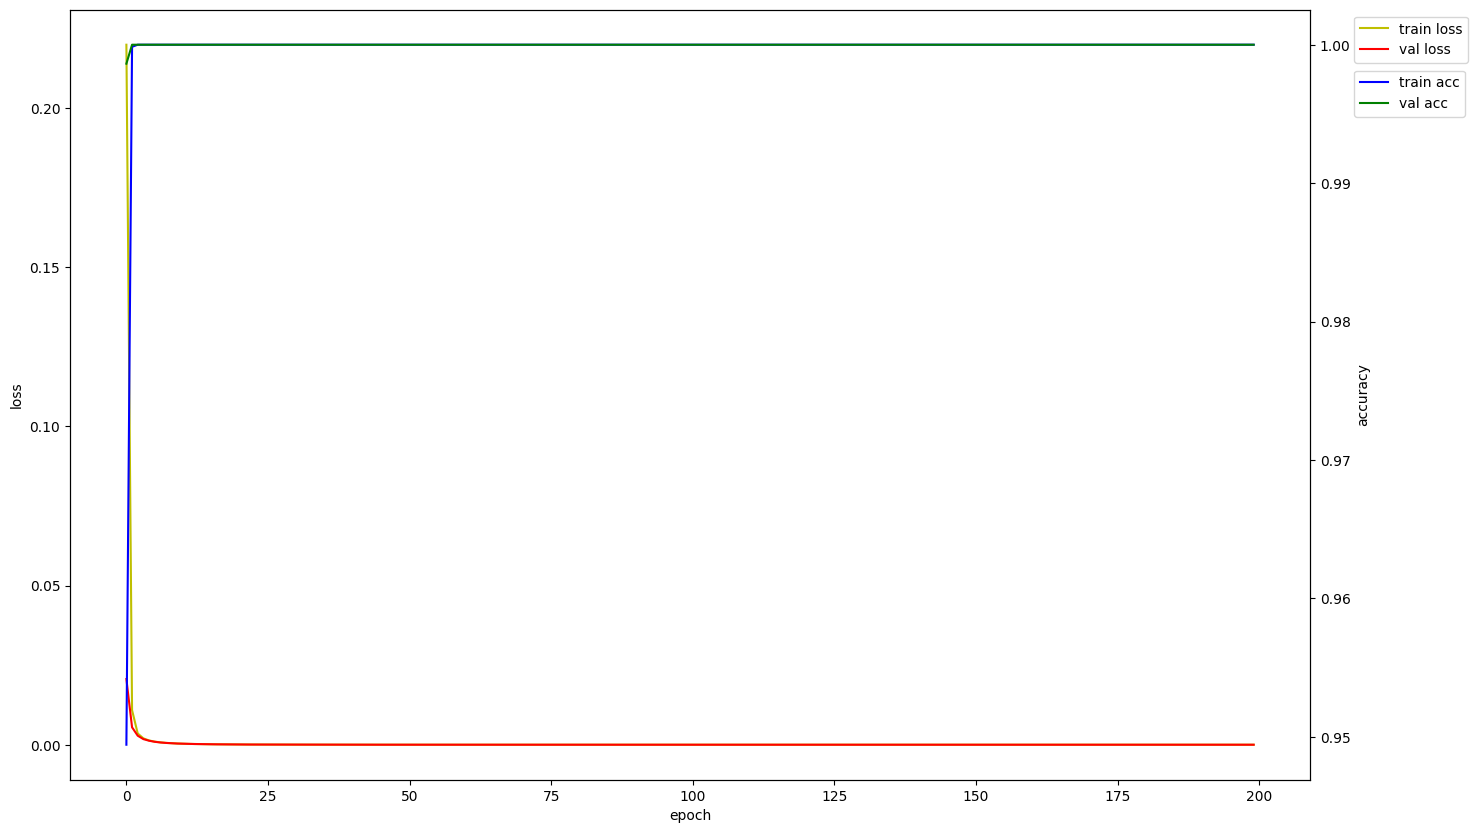

In [34]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left', bbox_to_anchor=(1.03, 1))


acc_ax.plot(history.history['acc'], 'b', label = 'train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 'upper left',bbox_to_anchor=(1.03, 0.93))

plt.show()

In [35]:
# 저장한 모델 가져오기
## val_acc가 1로 수렴하게 되면서 confusion_matrix의 형태가 FP, TN의 값이 0이 됨
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model_1 = load_model(savepath)

y_pred = model.predict(X_val)

multilabel_confusion_matrix(np.argmax(y_val, axis = 1), np.argmax(y_pred, axis = 1))

23/23 [==============================] - 0s 2ms/step


array([[[587,   0],
        [  0, 143]],

       [[588,   0],
        [  0, 142]],

       [[569,   0],
        [  0, 161]],

       [[588,   0],
        [  0, 142]],

       [[588,   0],
        [  0, 142]]], dtype=int64)